In [44]:
import pandas as pd
import pandahouse
import numpy as np
import hashlib
import seaborn as sns
from scipy import stats

# Подключение к базе данных

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230420'
}

# Выгрузка данных в датафрейм

In [3]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-04-01' and '2023-04-07'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

df

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750
...,...,...,...,...,...
20026,1,132567,45,296,0.152027
20027,1,30872,11,59,0.186441
20028,2,25383,42,127,0.330709
20029,2,139020,24,114,0.210526


# Построим гистограмму

In [4]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(11.7,8.27)})

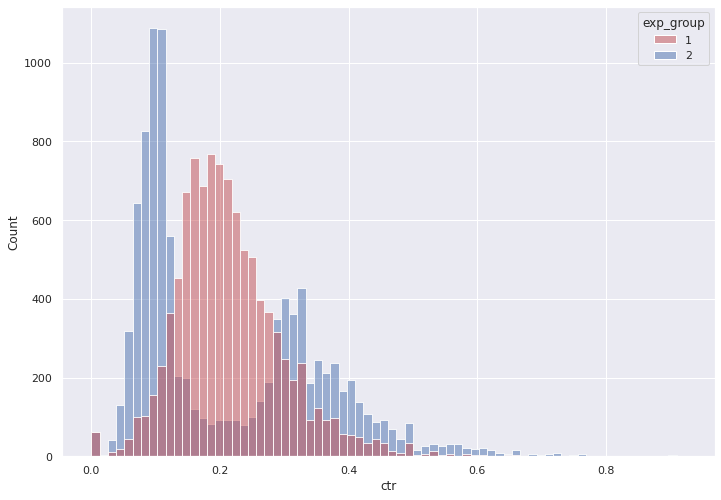

In [5]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

# T-тест Стьюдента

In [6]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

# Тест Манна-Уитни

In [7]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

In [81]:
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 1].ctr.sample().values[0] > df[df.exp_group == 2].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B')

В 56.61 % случаев A > B


# Пуассоновский бутстрэп

Функция рассчета глобального CTR

In [8]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [9]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

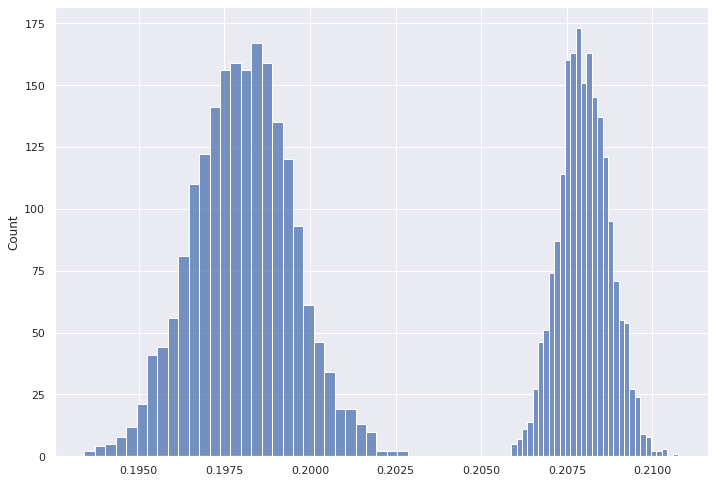

In [10]:
sns.histplot(ctr1)
sns.histplot(ctr2)

<AxesSubplot:ylabel='Count'>

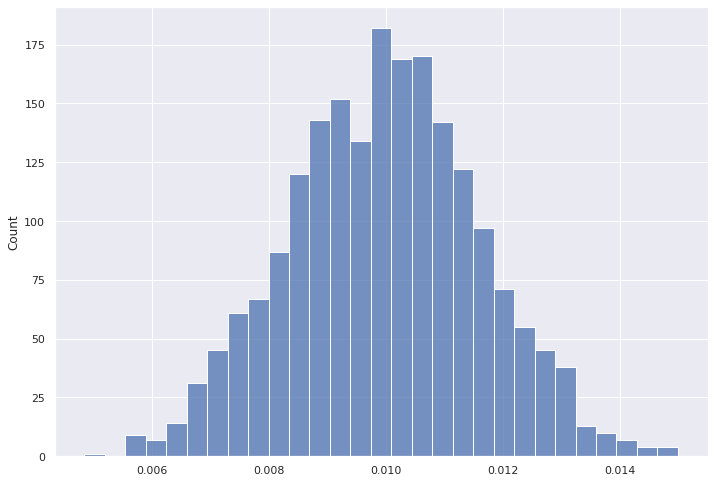

In [11]:
#Разница между глобальными CTR

sns.histplot(ctr1 - ctr2)

# Сглаживание CTR в двух группах

Функция сглаживания CTR

In [12]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [21]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()
group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()

In [22]:
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

<AxesSubplot:xlabel='smothed_ctr', ylabel='Count'>

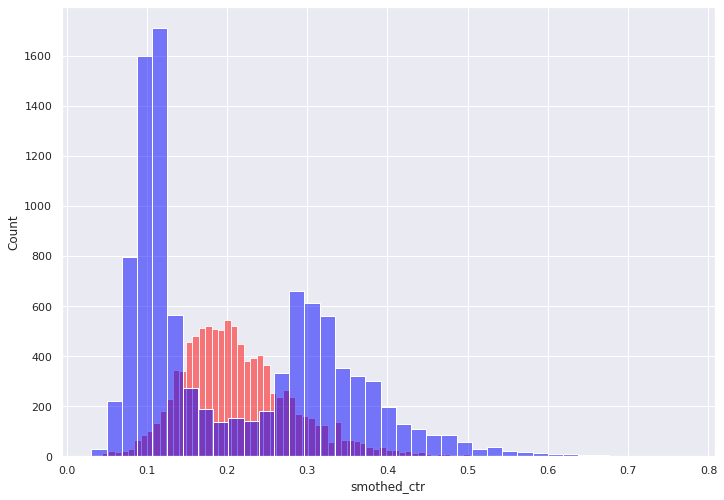

In [26]:
sns.histplot(group1.smothed_ctr, color=[1.0, 0.0, 0.0], alpha=0.5) 
sns.histplot(group2.smothed_ctr, color=[0.0, 0.0, 1.0], alpha=0.5)  

# Сравнение двух групп со сглаженным CTR T-тестом

In [29]:
stats.ttest_ind(group1[group1.exp_group == 1].ctr,
                group2[group2.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

# Бакетное преобразование

Функция хэширования с солью

In [73]:
def ab_split(id, salt='exp_mess_1', n_groups=50):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [77]:
df['bucket_ctr'] = df.user_id.apply(ab_split)

# Сравнение двух групп T-тестом поверх бакетного преобразования

In [78]:
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr, 
                df[df.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=1.2408670070947334, pvalue=0.21466941821289226)

# Сравнение двух групп тестом Манна-Уитни поверх бакетного преобразования

In [79]:
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=50658846.5, pvalue=0.21639251851484642)

Сравнение CTR в двух группах проведено несколькими тестами с преобразованием и без, а так же изучение распределений на гистограмме. Можно сделать несколько выводов: 
1. Распределение во второй группе (новый алгоритм "Рекомендации похожих на лайкнутые постов") двухмодальное. На графике видна просадка 2023-04-03 по количеству просмотров и лайков. Так как в данных не обнаружено влияющих на это факторов, это может быть связано с работой нового алгоритма.
2. Из за того что одно из распределений двухмодальное, Т-тест не работает даже со сглаженным CTR и бакетным преобразованием.
3. Тест Манна-Уитни показал что есть отличие в группах. Пуассоновский бутстрэп показал что разница существенная, причём в первой группе групповой CTR выше чем во второй.
4. На данном этапе я бы не рекомендовал раскатывать новый алгоритм на всех пользователей.  